<a href="https://colab.research.google.com/github/yashveersinghsohi/face_mask_detection/blob/main/ResNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Required Packages

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.models as models
from torchvision import transforms
import time
from tqdm.autonotebook import tqdm
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import inspect
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import numpy as np

# Creating Data loaders

In [3]:
ROOT_DIR = "/content/drive/Shareddrives/CIS522/"

with open(ROOT_DIR+"imgs.npy", "rb") as f:
  imgs = np.load(f)

with open(ROOT_DIR+"labels.npy", "rb") as f:
  labels = np.load(f)

In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    imgs, 
    labels, 
    test_size=0.1, 
    random_state=42
  )

X_train, X_val, y_train, y_val = train_test_split(
    X_train, 
    y_train, 
    test_size=0.1, 
    random_state=42
  )

def reshape_arrays(arr):
  return arr.reshape((arr.shape[0], 1, arr.shape[1], arr.shape[2]))

X_train = reshape_arrays(X_train)
X_val = reshape_arrays(X_val)
X_test = reshape_arrays(X_test)

X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

((9478, 1, 224, 224),
 (1054, 1, 224, 224),
 (1171, 1, 224, 224),
 (9478,),
 (1054,),
 (1171,))

In [5]:
X_train = torch.Tensor(X_train)
X_val = torch.Tensor(X_val)
X_test = torch.Tensor(X_test)

y_train = torch.Tensor(y_train)
y_val = torch.Tensor(y_val)
y_test = torch.Tensor(y_test)

train = TensorDataset(X_train, y_train)
val = TensorDataset(X_val, y_val)
test = TensorDataset(X_test, y_test)

train_dataloader = DataLoader(train, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test, batch_size=32, shuffle=True)

# Model

In [6]:
class ResNet(nn.Module):
  def __init__(self, in_channels=1):
    super(ResNet, self).__init__()

    self.model = models.resnet50(pretrained=True)
    self.model.conv1 = nn.Conv2d(in_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
    num_ftrs = self.model.fc.in_features
    self.model.fc = nn.Linear(num_ftrs, 3)

  def forward(self, x):
    return self.model(x)


resnet = ResNet()

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [7]:
input = torch.randn((16,1,244,244))
output = resnet(input)
print(output.shape)

print(resnet)

torch.Size([16, 3])
ResNet(
  (model): ResNet(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Seque

In [8]:
if torch.cuda.is_available():
    device = torch.device("cuda") 
else:
    device = torch.device("cpu")

# Training

In [9]:
def calculate_metric(metric_fn, true_y, pred_y):
  if metric_fn == accuracy_score:
    return metric_fn(true_y, pred_y)
  else:
    return metric_fn(true_y, pred_y, average="macro")
    
def print_scores(p, r, f1, a, batch_size):
  for name, scores in zip(("precision", "recall", "F1", "accuracy"), (p, r, f1, a)):
    print(f"\t{name.rjust(14, ' ')}: {sum(scores)/batch_size:.4f}")

In [10]:
# model:
model = ResNet().to(device)

# params you need to specify:
epochs = 5
# batch_size = 50

# Dataloaders
# train_loader, val_loader = get_data_loaders(batch_size, batch_size)

# loss function and optimiyer
loss_function = nn.CrossEntropyLoss() # your loss function, cross entropy works well for multi-class problems

# optimizer, I've used Adadelta, as it wokrs well without any magic numbers
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4) # Using Karpathy's learning rate constant

start_ts = time.time()

losses = []
batches = len(train_dataloader)
val_batches = len(val_dataloader)
best_loss = float("inf")

# loop for every epoch (training + evaluation)
for epoch in range(epochs):
  total_loss = 0

  # progress bar (works in Jupyter notebook too!)
  progress = tqdm(enumerate(train_dataloader), desc="Loss: ", total=batches)

  # ----------------- TRAINING  -------------------- 
  # set model to training
  model.train()
    
  for i, data in progress:
    X, y = data[0].to(device), data[1].to(device)
      
    # training step for single batch
    model.zero_grad()
    outputs = model(X)
    loss = loss_function(outputs, torch.tensor(y, dtype=torch.long, device=device))
    loss.backward()
    optimizer.step()
      
    # getting training quality data
    current_loss = loss.item()
    total_loss += current_loss
      
    # updating progress bar
    progress.set_description("Loss: {:.4f}".format(total_loss/(i+1)))
        
  # releasing unceseccary memory in GPU
  if torch.cuda.is_available():
    torch.cuda.empty_cache()
    
  # ----------------- VALIDATION  ----------------- 
  val_losses = 0
  precision, recall, f1, accuracy = [], [], [], []
    
  # set model to evaluating (testing)
  model.eval()
  with torch.no_grad():
    for i, data in enumerate(val_dataloader):
      X, y = data[0].to(device), data[1].to(device)
        
      outputs = model(X) # this get's the prediction from the network
      
      val_losses += loss_function(outputs, torch.tensor(y, dtype=torch.long, device=device))
        
      predicted_classes = torch.max(outputs, 1)[1] # get class from network's prediction
        
      # calculate P/R/F1/A metrics for batch
      for acc, metric in zip((precision, recall, f1, accuracy), 
                             (precision_score, recall_score, f1_score, accuracy_score)):
          acc.append(
              calculate_metric(metric, y.cpu(), predicted_classes.cpu())
          )
  
  if (val_losses/val_batches)<best_loss:
    best_model = model
    torch.save(best_model.state_dict(), "/content/checkpoints/ResNet") 
    best_loss = (val_losses/val_batches)

  print(f"Epoch {epoch+1}/{epochs}, training loss: {total_loss/batches}, validation loss: {val_losses/val_batches}")
  print_scores(precision, recall, f1, accuracy, val_batches)
  losses.append(total_loss/batches) # for plotting learning curve
print(f"Training time: {time.time()-start_ts}s")

Loss:   0%|          | 0/297 [00:00<?, ?it/s]

Epoch 1/5, training loss: 0.12638361288566982, validation loss: 0.06581468880176544
	     precision: 0.9700
	        recall: 0.9707
	            F1: 0.9689
	      accuracy: 0.9725


Loss:   0%|          | 0/297 [00:00<?, ?it/s]

Epoch 2/5, training loss: 0.060727466166102535, validation loss: 0.2692669928073883
	     precision: 0.9181
	        recall: 0.9141
	            F1: 0.9057
	      accuracy: 0.9100


Loss:   0%|          | 0/297 [00:00<?, ?it/s]

Epoch 3/5, training loss: 0.050190404926501966, validation loss: 0.061009883880615234
	     precision: 0.9762
	        recall: 0.9770
	            F1: 0.9750
	      accuracy: 0.9762


Loss:   0%|          | 0/297 [00:00<?, ?it/s]

Epoch 4/5, training loss: 0.027738987318009237, validation loss: 0.15764829516410828
	     precision: 0.9389
	        recall: 0.9349
	            F1: 0.9316
	      accuracy: 0.9355


Loss:   0%|          | 0/297 [00:00<?, ?it/s]

Epoch 5/5, training loss: 0.03531290893521323, validation loss: 0.02799079567193985
	     precision: 0.9894
	        recall: 0.9893
	            F1: 0.9888
	      accuracy: 0.9895
Training time: 1006.3990912437439s


In [13]:
test_losses = 0
precision, recall, f1, accuracy = [], [], [], []
test_batches = len(test_dataloader)
# set model to evaluating (testing)
best_model.eval()
with torch.no_grad():
  for i, data in enumerate(test_dataloader):
    X, y = data[0].to(device), data[1].to(device)
        
    outputs = best_model(X) # this get's the prediction from the network
      
    test_losses += loss_function(outputs, torch.tensor(y, dtype=torch.long, device=device))
        
    predicted_classes = torch.max(outputs, 1)[1] # get class from network's prediction
        
    # calculate P/R/F1/A metrics for batch
    for acc, metric in zip((precision, recall, f1, accuracy), 
                           (precision_score, recall_score, f1_score, accuracy_score)):
        acc.append(
            calculate_metric(metric, y.cpu(), predicted_classes.cpu())
        )
print(f"testing loss: {test_losses/test_batches}")
print_scores(precision, recall, f1, accuracy, test_batches)

testing loss: 0.05232465639710426
	     precision: 0.9887
	        recall: 0.9892
	            F1: 0.9884
	      accuracy: 0.9882


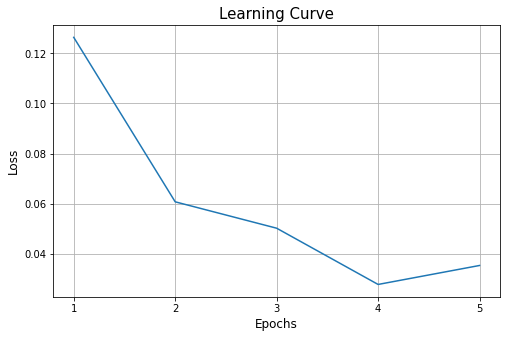

In [14]:
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(list(range(1, 6)), losses)
ax.set_xlabel("Epochs", size=12)
ax.set_ylabel("Loss", size=12)
ax.set_title("Learning Curve", size=15)
ax.set_xticks(list(range(1, 6)))
ax.grid()
plt.show()